In [1]:
from datetime import datetime
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

# Exploratory Data Analysis

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("./dataset/demo_lending_club_training_complete_with_partition_fast.csv")

In [4]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,Partition
0,126791625,13000.0,13000.0,13000.0,36 months,14.08,444.82,C,C3,Funeral Director,10+ years,MORTGAGE,60000.0,Not Verified,Jan-2018,0,n,NaN,other,Other,786xx,TX,38.90,0.0,Sep-2005,720.0,724.0,0.0,60.0,NaN,12.0,0.0,18811.0,43.7,25.0,w,0.0,0.0,14483.528029,14483.53,13000.00,1483.53,0.0,0.00,0.000,Dec-2018,10045.50,NaN,Mar-2019,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,259491.0,0.0,3.0,0.0,2.0,16.0,47341.0,53.0,1.0,3.0,6709.0,47.0,43000.0,2.0,1.0,2.0,6.0,23590.0,10389.0,59.3,0.0,0.0,148.0,120.0,12.0,12.0,2.0,19.0,NaN,4.0,60.0,0.0,3.0,4.0,4.0,5.0,12.0,8.0,11.0,4.0,12.0,0.0,0.0,0.0,2.0,96.0,25.0,0.0,0.0,313949.0,66152.0,25500.0,74063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN,T
1,90194469,8000.0,8000.0,8000.0,36 months,16.99,285.19,D,D1,MANAGER,2 years,RENT,37900.0,Not Verified,Sep-2016,1,n,NaN,credit_card,Credit card refinancing,012xx,MA,19.60,0.0,Oct-2004,660.0,664.0,1.0,35.0,NaN,7.0,0.0,7152.0,82.2,23.0,w,0.0,0.0,6879.460000,6879.46,4873.01,1991.45,15.0,0.00,0.000,Mar-2019,50.00,NaN,Mar-2019,499.0,0.0,0.0,47.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,22040.0,1.0,1.0,0.0,0.0,30.0,14888.0,68.0,2.0,6.0,2012.0,72.0,8700.0,0.0,4.0,3.0,6.0,3149.0,0.0,100.1,0.0,0.0,143.0,132.0,4.0,4.0,0.0,4.0,40.0,4.0,40.0,1.0,3.0,5.0,3.0,11.0,5.0,6.0,18.0,5.0,7.0,0.0,0.0,0.0,2.0,68.2,100.0,0.0,0.0,30747.0,22040.0,5000.0,22047.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,Y,Jan-2019,ACTIVE,Jan-2019,1474

In [5]:
df.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,29990.000000,30000.00000,30000.000000,30000.000000,30000.000000,14827.000000,5114.000000,30000.000000,30000.000000,30000.000000,29972.00000,30000.000000,30000.0,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,0.0,30000.000000,30000.000000,29998.000000,7899.000000,30000.0,546.000000,546.000000,30000.000000,28555.000000,2.855500e+04,12050.000000,12050.000000,12050.000000,12050.000000,11740.000000,1.205000e+04,10453.000000,12050.000000,12050.000000,12050.000000,12049.000000,28555.000000,12050.000000,12050.000000,12050.000000,28984.000000,28555.000000,28630.000000,28610.000000,29998.000000,30000.000000,27703.000000,28555.000000,28555.000000,28555.000000,28984.000000,28652.000000,7060.000000,26029.00000,9983.000000,28555.000000,28555.000000,28555.000000,28784.000000,28555.000000,28555.000000,28555.000000,28555.000000,28555.000000,28784.000000,27501.000000,28555.000000,28555.000000,28555.000000,28551.000000,28620.000000,29984.000000,29999.000000,2.855500e+04,2.898400e+04,28984.000000,2.855500e+04,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,379.000000,390.000000,390.000000,390.000000,390.000000,146.000000,150.0,150.000000,150.0,150.000000,97.000000,150.000000,150.000000,745.000000,745.000000,745.000000
mean,5.646833e+07,14342.378333,14332.245833,14313.522684,13.242834,435.792302,7.592568e+04,0.198967,18.333403,0.31260,696.080333,700.080433,0.652700,34.516423,70.982401,11.565433,0.213533,16085.005533,51.90745,24.959033,0.0,0.0,14752.824670,14733.895075,12129.320180,2385.399237,1.455079,236.650192,39.641608,5376.741016,NaN,677.173767,660.056500,0.017601,43.889986,1.0,112032.579341,19.389744,0.004600,224.632324,1.415669e+05,1.032531,2.833029,0.780415,1.745892,19.861244,3.611814e+04,71.263656,1.403402,2.997510,5489.410456,58.227903,32514.764770,1.083320,1.613527,2.319751,4.690795,13564.125932,10133.159308,59.970902,0.008401,11.182067,125.603112,181.121835,13.257503,7.986412,1.674407,24.160

In [6]:
df.shape

(30000, 150)

# Feature Transformation

In [7]:
numeric_transform = SimpleImputer(strategy='constant', fill_value=0)
categoric_tranform = Pipeline(
    steps=[
        ('null_imputation', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

In [8]:
# Col transfomer automatically handles right cols via datatypes
col_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transform, make_column_selector(dtype_include=[float,int])),
        ('categoric', categoric_tranform, make_column_selector(dtype_include=object))
    ]
)

# Partitioning

In [9]:
training_data = df[df['Partition'] == "T"].drop(labels=['id','Partition'], axis=1)

In [10]:
training_data.shape

(19200, 148)

In [11]:
validation_data = df[df['Partition'] == "V"].drop(labels=['id', 'Partition'], axis=1)

In [12]:
validation_data.shape

(4800, 148)

In [13]:
X_train = training_data.drop(labels='loan_status', axis=1)
y_train = training_data['loan_status']
X_val = validation_data.drop(labels='loan_status', axis=1)
y_val = validation_data['loan_status']

# Set up MLflow for Experiment Tracking

In [14]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment(experiment_name="kaggle_lending_club_xgboost")

<Experiment: artifact_location='mlflow-artifacts:/379835271244432248', creation_time=1675537719388, experiment_id='379835271244432248', last_update_time=1675537719388, lifecycle_stage='active', name='kaggle_lending_club_xgboost', tags={}>

In [15]:
mlflow.xgboost.autolog()

In [16]:
my_run_id = datetime.today().strftime('%Y-%m-%d_%H:%M:%S')
my_run_name="demo" + " " + my_run_id
run = mlflow.start_run(run_name=my_run_name)

In [17]:
mlflow.set_tag("Use Case Owner", "Dan Esposito")
mlflow.set_tag("Data Scientist", "Zhilei Ma")

# Model Training & Evalution

In [18]:
xgb_model = XGBClassifier(
    learning_rate=.1,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric=["logloss"],
    early_stopping_rounds=10,
    verbose=True
)

In [19]:
# Creates the model pipeline object:
model = Pipeline(
    steps=[
        ('col_transformer', col_transformer),
        ('model', xgb_model)
    ]
)

In [20]:
model[:-1].fit(X_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1394d5cd0>),
                                                 ('categoric',
                                                  Pipeline(steps=[('null_imputation',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                              

In [21]:
X_val = model[:-1].transform(X_val)

In [22]:
model.fit(
    X_train, 
    y_train, 
    model__eval_set=[(X_val, y_val)]
)

[22:29:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-logloss:0.60353
[1]	validation_0-logloss:0.53008
[2]	validation_0-logloss:0.46935
[3]	validation_0-logloss:0.41717
[4]	validation_0-logloss:0.37279
[5]	validation_0-logloss:0.33463
[6]	validation_0-logloss:0.30137
[7]	validation_0-logloss:0.27264
[8]	validation_0-logloss:0.24678
[9]	validation_0-logloss:0.22367
[10]	validation_0-logloss:0.20300
[11]	validation_0-logloss:0.18481
[12]	validation_0-logloss:0.16953
[13]	validation_0-logloss:0.15520
[14]	validation_0-logloss:0.14238
[15]	validation_0-logloss:0.13132
[16]	validation_0-logloss:0.12112
[17]	validation_0-logloss:0.11230
[18]	validation_0-logloss:0.10437
[19]	validation_0-logloss:0.09716
[20]	validation_0-logloss:0.09041
[21]	validation_0-logloss:0.08461
[22]	validation_0-logloss:0.07957
[23]	validation_0-logloss:0.07505
[24]	validati

2023/02/12 22:29:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/zhilei.ma/vscode/project/my_lending_club_xgboost/.venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1394d5cd0>),
                                                 ('categoric',
                                                  Pipeline(steps=[('null_imputation',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle...
                               eval_metric=['logloss'], feature_types=No

In [23]:
eval_results = model.named_steps['model'].evals_result()

# Log The Learning Curve in MLflow

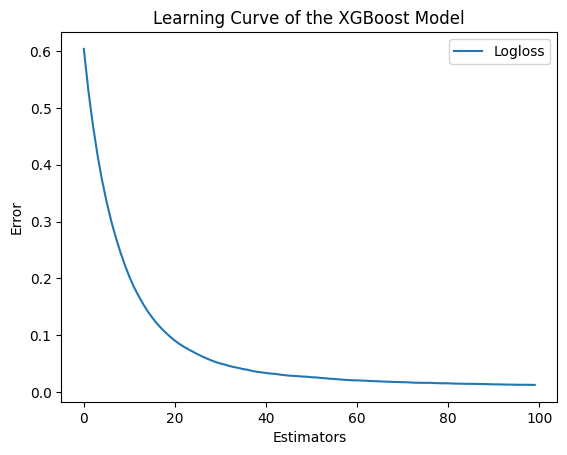

In [24]:
plt.plot(eval_results['validation_0']['logloss'], label='logloss')
plt.xlabel('Estimators')
plt.ylabel('Error')
plt.title('Learning Curve of the XGBoost Model')
plt.legend(['Logloss'])


# save the figure
plt.savefig('./artifact/learning_curve.png', dpi=300, bbox_inches='tight')


plt.show()

In [25]:
# Log the plotted learning curve in MLflow 
mlflow.log_artifact("./artifact/learning_curve.png")

# Serialization

In [26]:
# Serialize and save the trained model
joblib.dump(model, "model.pkl")

['model.pkl']

# Test & Validate Locally

In [27]:
!drum score -cd ./deploy --input ./dataset/demo_lending_club_scoring_1k.csv \
--target-type binary --positive-class-label 1 --negative-class-label 0 \
--verbose

Detected score mode
2023-02-12 22:30:24,556 WARNING drum:  Looks like there is a problem.
Traceback (most recent call last):
  File "/Users/zhilei.ma/vscode/project/my_lending_club_xgboost/.venv/bin/drum", line 8, in <module>
    main()
  File "/Users/zhilei.ma/vscode/project/my_lending_club_xgboost/.venv/lib/python3.9/site-packages/datarobot_drum/drum/main.py", line 104, in main
    runtime.cm_runner.run()
  File "/Users/zhilei.ma/vscode/project/my_lending_club_xgboost/.venv/lib/python3.9/site-packages/datarobot_drum/drum/drum.py", line 476, in run
    self._run_predictions_pipelines_in_mlpiper()
  File "/Users/zhilei.ma/vscode/project/my_lending_club_xgboost/.venv/lib/python3.9/site-packages/datarobot_drum/drum/drum.py", line 826, in _run_predictions_pipelines_in_mlpiper
    self._pipeline_executor.init_pipeline()
  File "/Users/zhilei.ma/vscode/project/my_lending_club_xgboost/.venv/lib/python3.9/site-packages/mlpiper/pipeline/executor.py", line 276, in init_pipeline
    self._init_p

In [ ]:
!drum validation  --code-dir . --input ./dataset/demo_lending_club_scoring_10k.csv \
--target-type binary --positive-class-label 1 --negative-class-label 0

In [ ]:
!drum --help